# Abrupt Fires and Landslides
Authors: Nick Colaianne, David Cúñes, Sebastien Lenard, Jill Marshal, Emily Rexer

Main notebook for integrating code. 

## Background and Motivation
TODO: Explain why this project is relevant and what we hope to discover

Mass wasting and landslides are major processes affecting the erosion of the Earth's surface. But their study remains difficult as the erosion products can be rapidly evacuated during the raining season. Numerical modeling allows to improve our knowledge of landsliding by simulating mountains and processes through numerical solving of the mathematical equations of the processes.

Here, we focus on a short-timescale question (over a few decades). How the alternance of a dry/fire season with a wet/rain season affect the properties of the soil? Which impact on the volume of shallow landslides (i.e. soil mass wasting) during an extreme rainfall event, at the following of an extreme fire?

Setting: a small drainage basin in Oregon.

## Table of Contents
1. Initializing the Grid and its fields (DEM, topographic and soil properties).
2. [Stochastic Fire](https://landlab.readthedocs.io/en/latest/reference/components/fire_generator.html).
3. [Flow](https://landlab.readthedocs.io/en/master/reference/bmi/index.html?highlight=priorityflood#landlab.bmi.components.PriorityFloodFlowRouter).
3. [Bedrock landslider](https://landlab.readthedocs.io/en/master/reference/components/bedrock_landslider.html?highlight=hyland).
4. [Space: Erosion and sediment flux](https://landlab.readthedocs.io/en/master/reference/components/space.html?highlight=space).
5. Running several iterations.

potential sections: [vegetation](https://landlab.readthedocs.io/en/latest/reference/components/vegetation_dynamics.html), [rainfall](https://landlab.readthedocs.io/en/latest/reference/components/uniform_precip.html), [SPACE](https://landlab.readthedocs.io/en/latest/reference/components/space.html#module-landlab.components.space.space_large_scale_eroder)

### Resources
[all landlab components](https://landlab.readthedocs.io/en/latest/reference/components/index.html#api-components)

We start to import all libraries required by this tutorial.

In [14]:
from bmi_topography import Topography # includes the BMI library to import the DEM of the drainage basin
import copy

# Libraries for scientific computing (ndarrays) and plotting
import numpy as np
import matplotlib as mpl; import matplotlib.pyplot as plt

# Landlab libraries/methods
from landlab.io import read_esri_ascii # library to read the file of the downloaded DEM
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid # Component to manage the grid and methods for display
from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler, BedrockLandslider
from landlab.components import SpaceLargeScaleEroder

# personal library for this notebook (for plotting results)
from my_plotting import my_plotting
from my_landslide_plot import my_landslide_plot
#import sys, time, os
#from pathlib import Path
#, write_esri_ascii
#from landlab.io.netcdf import read_netcdf
#from landlab.utils import get_watershed_mask

## 1. Initializing the Grid and its fields (DEM, topographic and soil properties).
Here, we get the 30m-STRM DEM covering a drainage basin in Oregon to create the grid on which the tutorial will work. Then, we compute the topographic slope and topographic drainage area, which are added to the grid as fields for the landslide component. We also determine and add soil properties, which are needed by the landlide component to compute landslide failure probability.

### 1.1 Download the DEM.

We download the DEM.

In [2]:
# imports the DEM into the memory (note: a warning is raised from the demo key). Requires the BMI library bmi_topography
# Large drainage basin
DEMLongLatCoordinates = {'east': -123.795973, 'north': 44.013602, 'west': -123.860848, 'south': 43.972829}
# Small drainage basin, only used for tests
# DEMLongLatCoordinates = {'east': -123.813606, 'north': 43.982382, 'west': -123.826646, 'south': 43.971911}
topo = Topography(
    dem_type="SRTMGL1",
    api_key = '1f3ea82738663688170f0d898b59ca1d',
    south=DEMLongLatCoordinates['south'],
    north=DEMLongLatCoordinates['north'],
    west=DEMLongLatCoordinates['west'],
    east=DEMLongLatCoordinates['east'],
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

We get some cache information and properties of the DEM and display the DEM. Coordinates in degrees.

/home/jupyter-sebastien.lenard@g-244c0/abrupt-perturbations/abrupt_fire_landslide/DEMData/SRTMGL1_43.972829_-123.860848_44.013602_-123.795973.asc
<xarray.DataArray 'SRTMGL1' (band: 1, y: 147, x: 234)>
array([[[ 93, 100, ..., 299, 291],
        [101, 108, ..., 303, 298],
        ..., 
        [338, 331, ..., 334, 356],
        [332, 323, ..., 350, 369]]], dtype=int32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 44.01 44.01 44.01 44.01 ... 43.97 43.97 43.97 43.97
  * x        (x) float64 -123.9 -123.9 -123.9 -123.9 ... -123.8 -123.8 -123.8
Attributes:
    transform:   (0.000277777778, 0.0, -123.860972222215, 0.0, -0.00027777777...
    res:         (0.000277777778, 0.000277777778)
    is_tiled:    0
    nodatavals:  (-32768.0,)
    scales:      (1.0,)
    offsets:     (0.0,)
    units:       meters
    location:    node


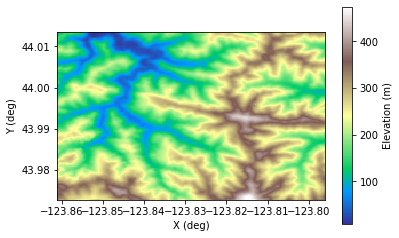

In [3]:
fname = topo.fetch(); print(fname)
dem = topo.load(); print(dem)

# Instantiates the RasterModelGrid by reading the ascii DEM file. 
# The coordinates and spacing are in degrees. The elevation field for this DEM and 
# the other fields referring to the DEM are named "topographic__elevation".
# the following returns the RasterModelGrid object and the array of elevations
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')     

# Plot the DEM
plt.figure()
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshow_grid(grid_geog, 'topographic__elevation', cmap =cmap,
            grid_units=("deg", "deg"), colorbar_label="Elevation (m)")
plt.show()

### 1.2. Reproject from geographic coordinate system into projected coordinate system.
We reproject the DEM into a new projected DEM with coordinates and cell-spacing in meters.

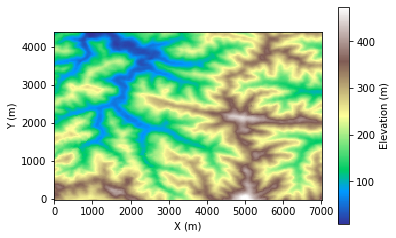

In [4]:
# We now need to create a second RasterModelGrid from this grid, to define the coordinates and 
# cell spacing  in meters 
# (30 meters, rather than the resolution in degrees indicated in the ascii files 0.000277777778)
dx=30 # meters, np.diff(grid.x_of_node)[0]
grid = RasterModelGrid ((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), dx)
grid.add_field('topographic__elevation', elev, at = 'node')

num_rows, num_columns = grid.shape 
node_spacing = grid.dx

# Plot the DEM
plt.figure()
imshow_grid(grid, 'topographic__elevation', cmap =cmap,
            grid_units=("m", "m"), colorbar_label="Elevation (m)")
plt.show()

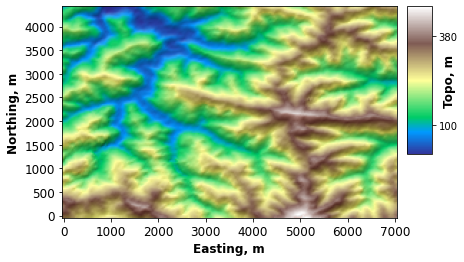

In [5]:
# Display the DEM with grey shading nice plotting function
my_plotting(grid, DA=False)

### 1.4. Initializing the soil properties.

In [6]:
_ = grid.add_zeros("soil__depth", at="node")
grid.at_node["soil__depth"][grid.core_nodes] = 1. #temporary till we add fires in

K_sed0 = 0.00001        # Baseline soil erodiblity
K_sed = np.ones(grid.shape) * K_sed0 # the initial soil erodibility per node

# Timesteps of the simulation
dt_sp = 1.0                   # timestep in years
timestep = dt_sp # in years
# Erodibility stepper
decay_time = dt_sp * 15    # time it takes the erodibility perturbutions to decay

# Instantiate the erodibility stepper
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)

## 2. Stochastic Fire

In [ ]:
# Burner
R_fire_mean = len(grid.x_of_node)*dx/500    # Mean fire radius in m. 1/20 the size of the grid.
fire_freq = 1/(2*dt_sp)          # Fire frequency in #/yr. This is one every 10
K_sed_boost = 5*K_sed0           # The increase in sediment erodibility due to fire

# Instantiate the burner
burner = Burner(fire_freq=fire_freq,
                R_fire_mean=R_fire_mean,
                K_sed_boost=K_sed_boost,
                dt=dt_sp)

## 3. Flow

We now compute the flow directions/flow accumulation using the first instance of Priority flood flow director/accumulator. (BMI interface)

Doc: https://landlab.readthedocs.io/en/master/reference/bmi/index.html?highlight=priorityflood#landlab.bmi.components.PriorityFloodFlowRouter.

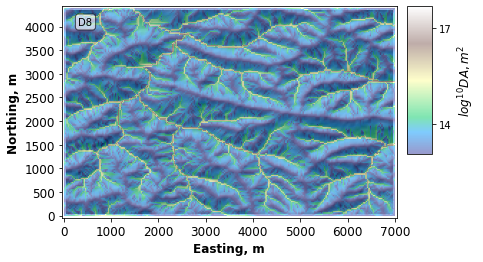

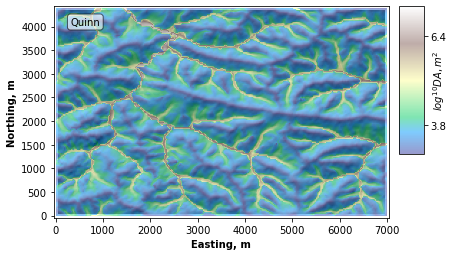

In [7]:
# Here, we only calculate flow directions using the first instance of the flow accumulator
flow_metric = "D8"
flow_router = PriorityFloodFlowRouter(
    grid,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=True,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
)

# We add some constraints on the boundaries of the DEM / outlet and watershed TODO: CLARIFY
grid.set_watershed_boundary_condition_outlet_id(
    0, grid.at_node['topographic__elevation'], -9999.0
)
grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True, left_is_closed=True,
    right_is_closed=True, top_is_closed=True)

# We run once the router and display the results
flow_router.run_one_step()

# Plot output products
my_plotting(grid, topo=False, hill_DA=True)

## 4. BedrockLandslider

Now we instantiate and run once the BedrockLandslider.

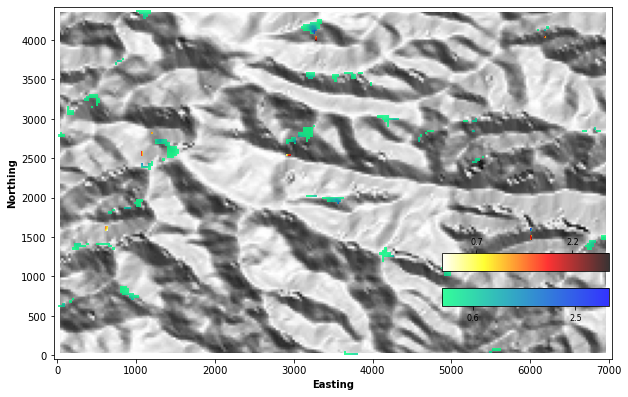

In [23]:
ls = BedrockLandslider(
    grid, 
    angle_int_frict= .5, #84, #have 40 degrees changed to %
    landslides_return_time=1e2, #changed from default of 1e3
    cohesion_eff = 1e3) #reduced from 1e3 - just taking a guess

# angle_int_frict in m/m (tangent and not degrees)
# landslides_return_time = 1 -> probability of sliding 100%
# cohesion_eff: Effective cohesion of material [m L^-1 T^-2].

np.random.seed(seed=5000) # stochastic sampling to trigger landslides
ls.run_one_step(dt=timestep)

# Show Landslide Erosion (Red/yellow) and deposition (green/blue) draped over the shaded topographic relief
my_landslide_plot(grid)

Text(0, 0.5, 'Landslide frequency')

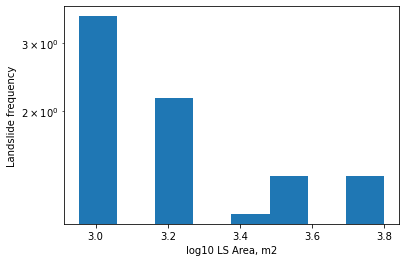

In [24]:
# Plot the landslide frequency 
plt.figure()
LS_size = np.array(ls.landslides_size) * grid.dx ** 2
counts, bins = np.histogram(np.log10(LS_size), 8)
plt.hist(np.log10(LS_size), log=True, bins=bins, density=True)
# counts, bins = np.histogram(LS_size, 10)
# plt.hist(LS_size, bins=bins)
plt.xlabel("log10 LS Area, m2")
plt.ylabel("Landslide frequency")

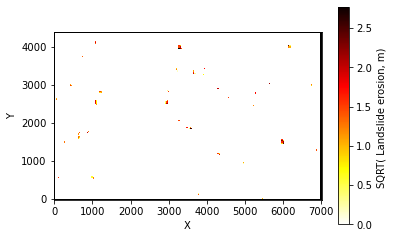

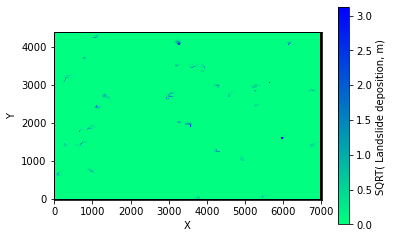

In [25]:
# Plot of Landslide Erosion 
cmap = copy.copy(mpl.cm.get_cmap("hot_r"))
imshow_grid(grid,np.sqrt(grid.at_node["landslide__erosion"]), colorbar_label = 'SQRT( Landslide erosion, m) ',cmap =cmap)
plt.show()

# Plot of Landslide Deposition 
cmap = copy.copy(mpl.cm.get_cmap("winter_r"))
imshow_grid(grid,np.sqrt(grid.at_node["landslide__deposition"]), colorbar_label = 'SQRT( Landslide deposition, m) ',cmap =cmap)
plt.show()

## 5. Space: Erosion and sediment flux

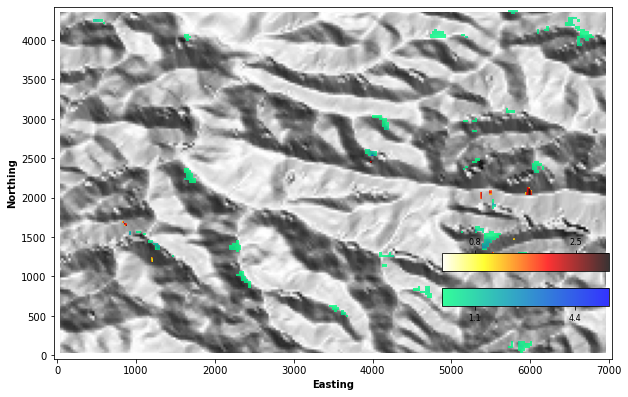

In [30]:
#We instantiate the large scale eroder
space = SpaceLargeScaleEroder(
    grid,
    K_sed=K_sed # defined by fire team, in soil properties now was 0.01, # erodibility for sediment
    K_br=0.01, # erodibility for bedrock here: sandstone
)

# parameters of the iterations
elapsed_time = 0.0
count = 0
run_time = 20 # years
sed_flux = np.zeros(int(run_time // timestep))
node_next_to_outlet = num_columns + 1

flow_router.run_one_step()
_ = space.run_one_step(dt=timestep)
sed_flux[count] = grid.at_node["sediment__flux"][node_next_to_outlet]

elapsed_time += timestep
count += 1
my_landslide_plot(grid)

## 6. Run several iterations

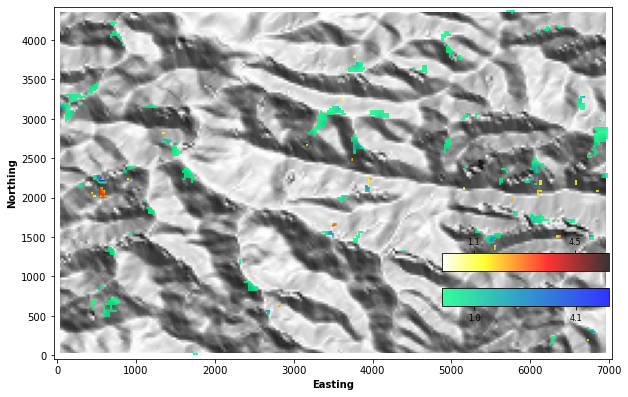

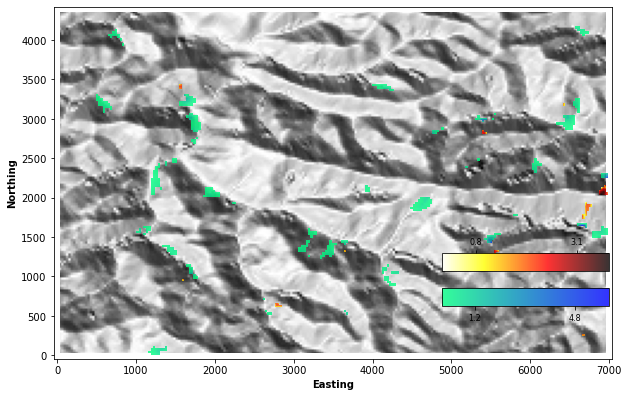

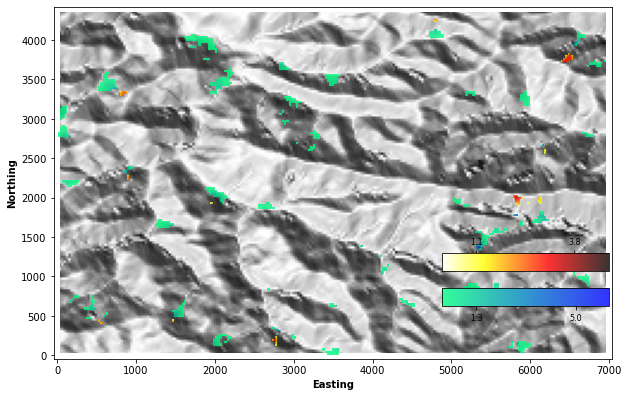

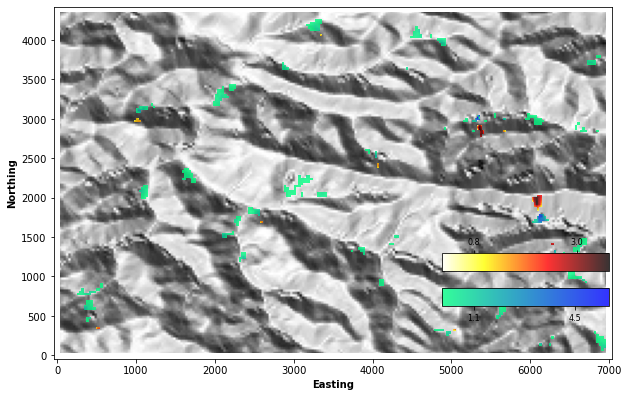

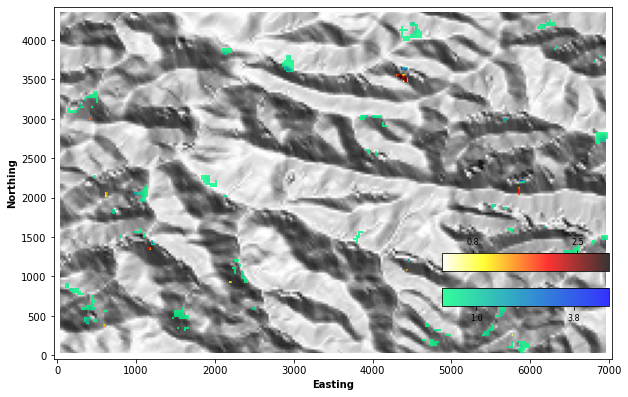

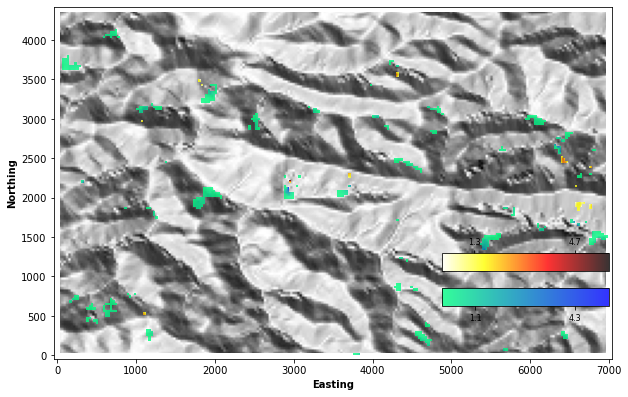

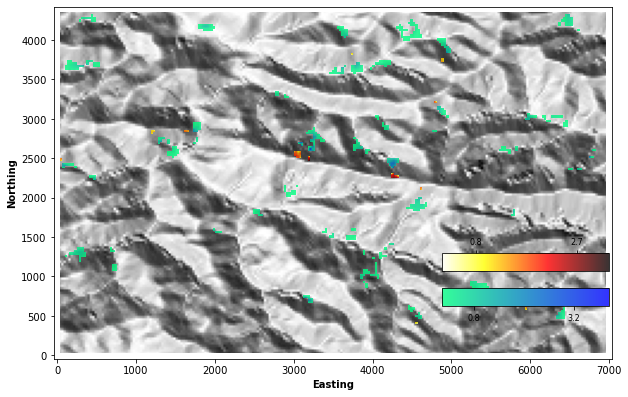

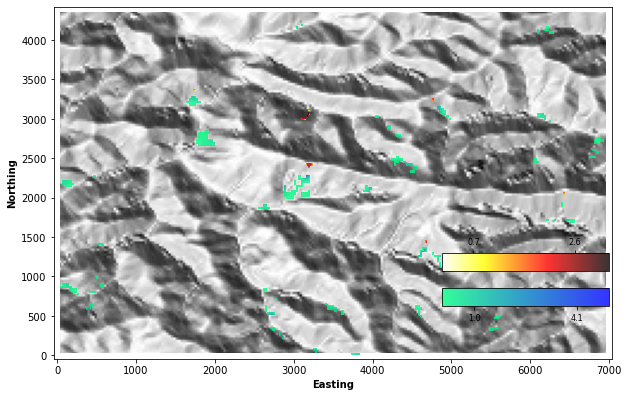

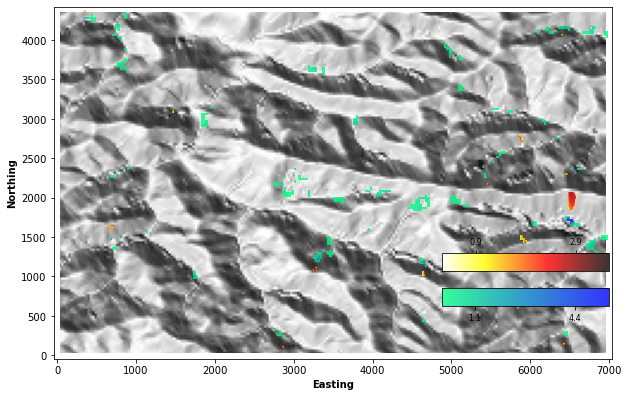

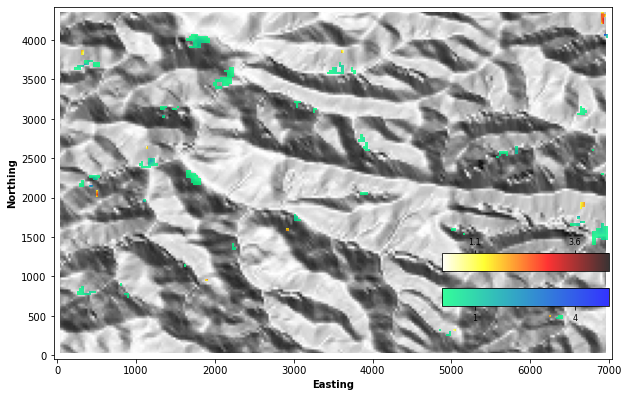

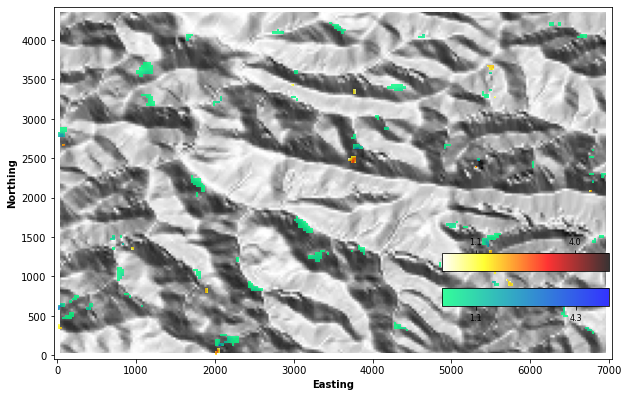

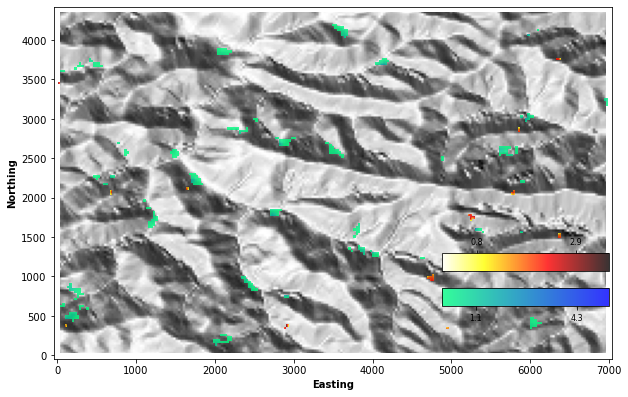

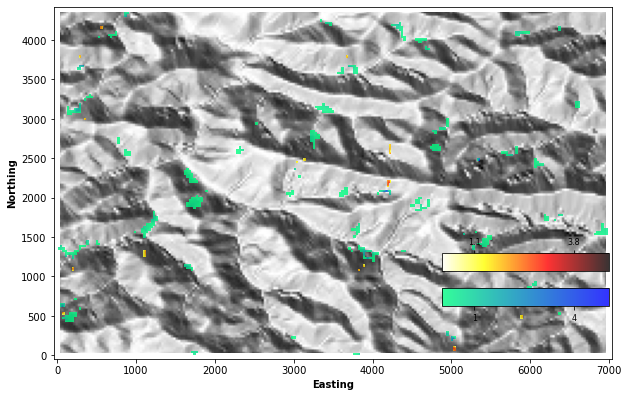

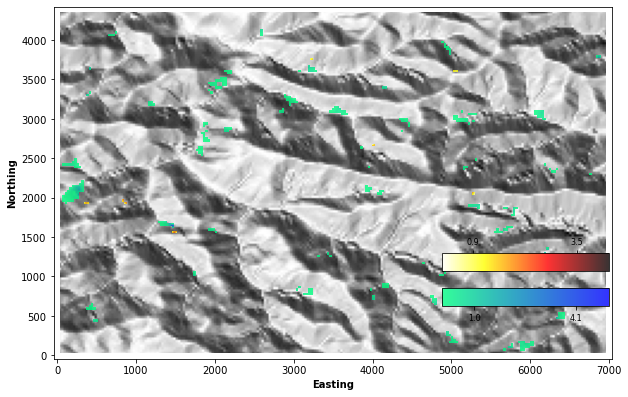

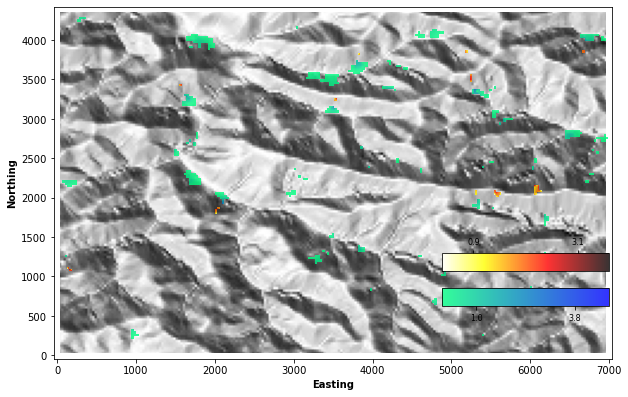

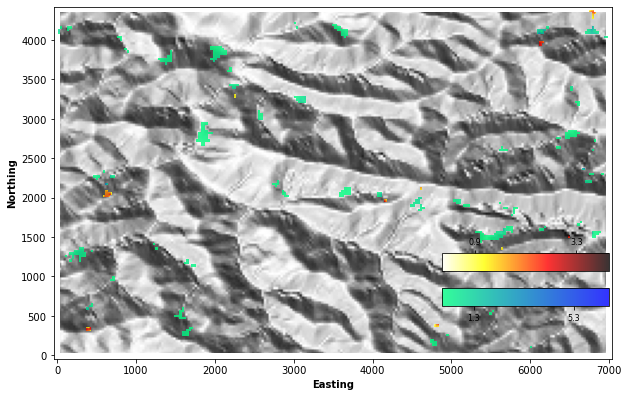

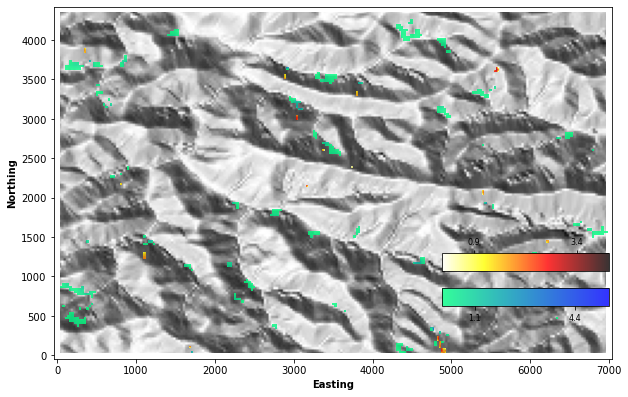

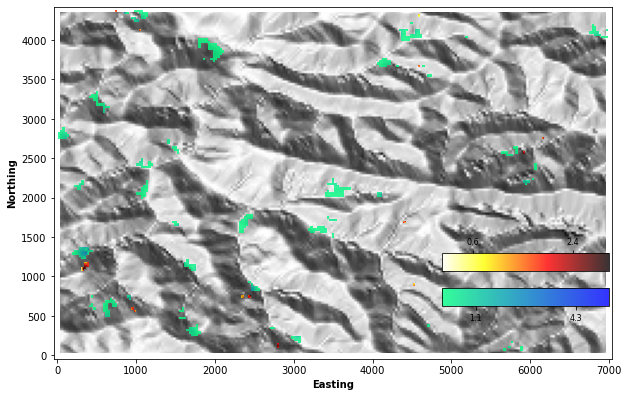

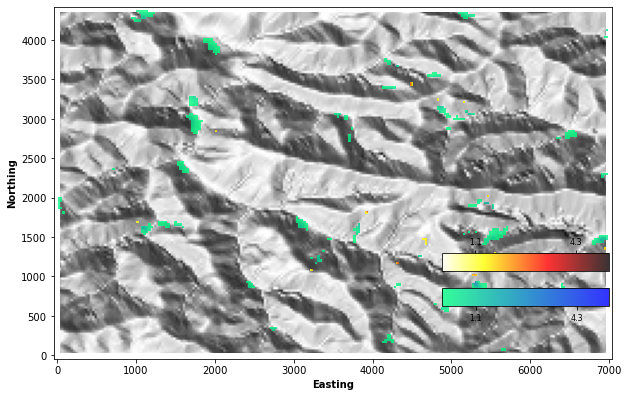

In [31]:
while elapsed_time < run_time:
    # run the fire trigger
    
    # run the bedrock landslide
    flow_router.run_one_step()
    ls.run_one_step(dt=timestep)
    
    # run space
    flow_router.run_one_step()
    _ = space.run_one_step(dt=timestep)
    sed_flux[count] = grid.at_node["sediment__flux"][node_next_to_outlet]
    
    elapsed_time += timestep
    count += 1
    my_landslide_plot(grid)